## Objective

Infer business closure from Yelp reviews.  

## Load Data

In [1]:
YELP_TOP_CITIES = ['Las Vegas', 'Phoenix', 'Toronto', 'Scottsdale', 'Charlotte']
CITIES = ['Las Vegas']
CATEGORIES = ['Restaurants']
REVIEW_START_DATE = '2015-01-01'
KEY_COL = 'business_id'
DATA_DIR = 'data'

In [2]:
import sys
import os
import time
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pprint

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns
sns.set()

In [4]:
%%time

# Load raw CSV files:
yelp_b_raw_df = pd.read_csv(
    os.path.join(DATA_DIR, 'yelp_b_raw.csv.gz'), 
    dtype=str, 
    index_col=None)
yelp_a_raw_df = pd.read_csv(
    os.path.join(DATA_DIR, 'yelp_a_raw.csv.gz'), 
    dtype=str, 
    index_col=None)
yelp_r_raw_df = pd.read_csv(
    os.path.join(DATA_DIR, 'yelp_r_raw.csv.gz'), 
    dtype=str, 
    index_col=None,
    parse_dates=['review_date'])

CPU times: user 1.31 s, sys: 93 ms, total: 1.41 s
Wall time: 1.4 s


In [5]:
#yelp_b_raw_df.info()

In [6]:
#yelp_a_raw_df.info()

In [7]:
#yelp_r_raw_df.info()

## Data Cleanup And Preprocessing

In [8]:
# The load process is time consuming; create a copy of the raw data and operate
# on it. This is the point to resume the processing if needed.
yelp_b_df = yelp_b_raw_df.copy()
yelp_a_df = yelp_a_raw_df.copy()
yelp_r_df = yelp_r_raw_df.copy()

#  Drop NAs:
yelp_b_df.dropna(inplace=True)
yelp_a_df.dropna(inplace=True)
yelp_r_df.dropna(inplace=True)

# Normalize city:
yelp_b_df['city'] = (
    yelp_b_df['city']
    .str.lower()
    .str.strip()
    .str.replace(r'[^a-z0-9]+', '_')
    #.str.replace('^$', 'none')
)

# Normalize neighborhood:
yelp_b_df['neighborhood'] = (
    yelp_b_df['neighborhood']
    .str.lower()
    .str.strip()
    .str.replace(r'[^a-z0-9]+', '_')
    #.str.replace('^$', 'none')
)

#  Normalize postal code:
yelp_b_df['postal_code'] = (
    yelp_b_df['postal_code']
    .str.lower()
    .str.strip()
    #.str.replace('^$', 'none')
)

# Keep only the businesses that have city, neighborhood and postal_code:
yelp_b_df = yelp_b_df[
    (yelp_b_df['city'] != '') & (yelp_b_df['neighborhood'] != '') & (yelp_b_df['postal_code'] != '') 
]

# Normalize business categories:
yelp_a_df['category'] = (
    yelp_a_df['category']
    .str.lower()
    .str.strip()
    .str.replace(r'[()]', '')
    .str.replace(r'[^a-z0-9]+', '_')
    .str.replace('^$', 'none')
)

# Keep only the categories that have a count over a certain threshold:
cat_cnt = yelp_a_df['category'].value_counts()
cat_cnt = cat_cnt[cat_cnt > 100]
yelp_a_df = yelp_a_df[yelp_a_df['category'].isin(cat_cnt.index)]

# Keep only the businesses that appear in all DF's:
from functools import reduce
common_business_ids = reduce(np.intersect1d, (yelp_b_df[KEY_COL].unique(),
                                              yelp_a_df[KEY_COL].unique(),
                                              yelp_r_df[KEY_COL].unique()))

yelp_b_df = yelp_b_df[yelp_b_df[KEY_COL].isin(common_business_ids)].reset_index(drop=True)
yelp_a_df = yelp_a_df[yelp_a_df[KEY_COL].isin(common_business_ids)].reset_index(drop=True)
yelp_r_df = yelp_r_df[yelp_r_df[KEY_COL].isin(common_business_ids)].reset_index(drop=True)

# Force column type:
yelp_b_df['is_open'] = yelp_b_df['is_open'].astype(np.int8)
yelp_b_df['stars']  = yelp_b_df['stars'].astype(np.float16)
yelp_b_df['review_count'] = yelp_b_df['review_count'].astype(np.int32)
yelp_b_df['latitude'] = yelp_b_df['latitude'].astype(np.float32, errors='ignore')
yelp_b_df['longitude'] = yelp_b_df['longitude'].astype(np.float32, errors='ignore')

yelp_r_df['review_stars'] = yelp_r_df['review_stars'].astype(np.float16)

# Sort review by date and business:
yelp_r_df.sort_values(by=['review_date', KEY_COL], inplace=True)

In [9]:
# Build city+neighborhood combo col (disambiguate the same nbr name in 
# multiple cities):
city_nbr_col = 'city_nbr'
yelp_b_df[city_nbr_col] = (
    yelp_b_df[['city', 'neighborhood']]
    .apply(lambda r: '_'.join(r.values), axis=1)
)

In [10]:
# Convert city+neighborhood into indicator cols:
yelp_b_df = pd.concat(
    [
        yelp_b_df,
        pd.get_dummies(yelp_b_df[city_nbr_col], prefix='nbr')
    ],
    axis=1
)
nbr_cols = [c for c in yelp_b_df.columns if c.startswith('nbr_')]

In [11]:
# Number of businesses per neighborhood:
bpnbr_cnt_col = 'bpnr_cnt'

bpnbr_counts = yelp_b_df[city_nbr_col].value_counts()
yelp_b_df[bpnbr_cnt_col] = (
    yelp_b_df[city_nbr_col].map(lambda n: bpnbr_counts[n])
    .fillna(0)
)

In [12]:
# Convert the postal code into indicator cols:
yelp_b_df = pd.concat(
    [
        yelp_b_df,
        pd.get_dummies(yelp_b_df['postal_code'], prefix='zip')
    ],
    axis=1
)
zip_cols = [c for c in yelp_b_df.columns if c.startswith('zip_')]

In [13]:
# Create category indicator columns:
yelp_b_df = pd.merge(
    yelp_b_df,
    (
        pd.get_dummies(
            yelp_a_df[[KEY_COL, 'category']].drop_duplicates(), # needed because of the attributes
            prefix='cat', 
            columns=['category']
        )
        .groupby(KEY_COL, as_index=False, sort=False)
        .sum()
    ),
    on=KEY_COL
)
cat_cols = [c for c in yelp_b_df.columns if c.startswith('cat_')]

In [14]:
# Convert stars to rating: -1 (bad), 0 (neutral), 1 (pos)
def make_rating(num_stars):
    return (-1 if num_stars <= 2
            else 0 if num_stars <= 3.5
            else 1)

rating_col = 'rating'
yelp_b_df[rating_col] = yelp_b_df['stars'].transform(make_rating)

In [15]:
# Add the number of categories for the business:
cat_cnt_col = 'cat_cnt'

yelp_b_df = pd.merge(
    yelp_b_df,
    (
        yelp_a_df
        .groupby(KEY_COL, sort=False)
        ['category']
        .nunique()
        .reset_index()
        .rename(columns={'category': cat_cnt_col})
    ),
    how='left',
    on=KEY_COL
)

In [16]:
yelp_b_df[cat_cnt_col] = yelp_b_df[cat_cnt_col].fillna(0)

In [17]:
# Add the number of businesses with the same name:
same_name_cnt_col = 'same_name_cnt'

same_name_counts = yelp_b_df['name'].value_counts()
yelp_b_df[same_name_cnt_col] = (
    yelp_b_df['name'].map(lambda n: same_name_counts[n])
    .fillna(0)
)

In [18]:
# Add a review sentiment col:
def review_sentiment(stars, pct=None, n=0):
    """Pick the most recent pct%/n reviews and assign -1, 0, 1 for bad, neutral, good.
       Sum the resulting values.
    """
    
    if pct is not None:
        n = int(len(stars) * pct / 100)
    return sum(
        map(lambda s:-1 if s <=2 else 0 if s <= 3.5 else 1, stars[-n:])
    )

review_sentiment_col = 'review_sentiment'

yelp_b_df = pd.merge(
    yelp_b_df,
    (
        yelp_r_df[[KEY_COL, 'review_stars']]
        .groupby(KEY_COL, as_index=False)
        .agg(review_sentiment, pct=10)
        .rename(columns={'review_stars': review_sentiment_col})
    ),
    on=KEY_COL
)

In [19]:
# Convert is_open into will_close complement to have positive == 1:
TARGET_COL = 'will_close'
yelp_b_df[TARGET_COL] = 1 - yelp_b_df['is_open']
POS_LABEL = 1
NEG_LABEL = 1 - POS_LABEL
POS_NAME = "Will Close"
NEG_NAME = "Stays Open"

In [20]:
yelp_b_df.shape

(4085, 241)

## Are The Stars Relevant?

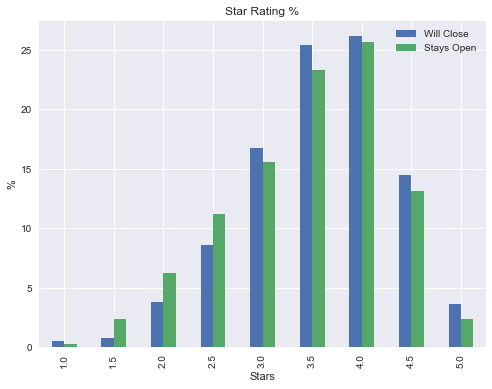

In [21]:
stars = yelp_b_df['stars'].unique()
stars.sort()
by_stars_df = pd.DataFrame(index=stars, columns=[POS_NAME, NEG_NAME])
by_stars_df[POS_NAME] = yelp_b_df[yelp_b_df[TARGET_COL] == POS_LABEL]['stars'].value_counts()
by_stars_df[NEG_NAME] = yelp_b_df[yelp_b_df[TARGET_COL] == NEG_LABEL]['stars'].value_counts()
by_stars_df = by_stars_df.transform(lambda c: c/c.sum()*100)

ax = by_stars_df.plot.bar(#secondary_y=[NEG_NAME], 
                          title='Star Rating %',
                          figsize=(8, 6))
ax.set_xlabel('Stars')
ax.set_ylabel('%')
plt.show()

**Obs:** Low rating is not a good predictor for business closing.

## Split into train and test sets.

Split by bussiness ID to prevent the model from learning a specific business thus skewing the test scores.

In [22]:
np.random.seed(seed=19590209)
test_business_ids = np.random.choice(common_business_ids, 
                                     size=int(common_business_ids.shape[0] * .20),
                                     replace=False)

In [23]:
# Sanity check on target distribution between the sets:
test_filter = yelp_b_df[KEY_COL].isin(test_business_ids)
train_filter = ~test_filter

train_set_is_open_dist = yelp_b_df[train_filter][TARGET_COL].value_counts(sort=False)
test_set_is_open_dist = yelp_b_df[test_filter][TARGET_COL].value_counts(sort=False)

print("Train set `{}' {}/{}: {:6d}/{:<6d} = {:6.03f}".format(
    TARGET_COL, POS_LABEL, NEG_LABEL,
    train_set_is_open_dist.loc[POS_LABEL], train_set_is_open_dist.loc[NEG_LABEL],
    train_set_is_open_dist.loc[POS_LABEL] / train_set_is_open_dist.loc[NEG_LABEL]
))
print(" Test set `{}' {}/{}: {:6d}/{:<6d} = {:6.03f}".format(
    TARGET_COL, POS_LABEL, NEG_LABEL,
    test_set_is_open_dist.loc[POS_LABEL], test_set_is_open_dist.loc[NEG_LABEL],
    test_set_is_open_dist.loc[POS_LABEL] / test_set_is_open_dist.loc[NEG_LABEL]
))

Train set `will_close' 1/0:    631/2637   =  0.239
 Test set `will_close' 1/0:    164/653    =  0.251


In [24]:
from sklearn.preprocessing import \
    scale
from sklearn.linear_model import \
    LogisticRegression
from sklearn.model_selection import \
    train_test_split
from sklearn.metrics import \
    f1_score, recall_score, precision_score, \
    roc_auc_score, roc_curve, auc, confusion_matrix
    
from imblearn import over_sampling

## Feature Selection
Gradually add features to the model and judge their predictive power.

In [25]:
COLS_NEED_SCALING = set([
    'stars',
    'review_count',
    rating_col,
    bpnbr_cnt_col,
    review_sentiment_col,
    cat_cnt_col,
    same_name_cnt_col
])

In [26]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
from collections import OrderedDict

def make_np_array(data, reshape=False):
    a = np.array(data)
    if reshape and len(a.shape) == 1:
        a = a.reshape(-1, 1)
    return a

def print_scores(score):
    l = max(map(len, score.keys()))
    for k, v in score.items():
        print("{k:{l}s}: {v:{vf}}".format(
            l=l, k=k, v=v, 
            vf=('.03f' if type(v) in [float, np.float64] else '')
        ))

def plot_roc_curve(fpr, tpr, auc_score=None, 
                   roc_label=None,
                   ax=None):
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = plt.gca()
    if auc_score is None:
        auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, 
            label='AUC={:.03f}'.format(auc_score))
    if not roc_label:
        roc_label = 'Classification'
    ax.set_title('ROC AUC For {}'.format(roc_label))
    ax.plot([0, 1], [0, 1], linestyle='--', color='red')
    ax.legend(loc='lower right')
    
def try_model(feature_list,
              do_scale=True,
              M=LogisticRegression, margs={}, 
              display_scores=True,
              plot_roc=True, roc_label=None,
              ros_ratio=0):
    '''Try model M(**margs) on data and return the scores
    '''
    
    # Make a copy of the data set:
    df = yelp_b_df.copy()
    
    # Scale cols as needed:
    if do_scale:
        scale_cols = set(feature_list).union(COLS_NEED_SCALING)
        if scale_cols:
            scale_cols = list(scale_cols)
            df[scale_cols] = scale(df[scale_cols])
    
    test_filter = df[KEY_COL].isin(test_business_ids)
    train_filter = ~test_filter

    train_df, test_df = \
        df[train_filter], df[test_filter]

    drop_cols = set(df.columns) - set(feature_list)
    drop_cols = drop_cols.union(set([KEY_COL, TARGET_COL]))
    X_train, X_test = \
        train_df.drop(labels=drop_cols, axis=1), test_df.drop(labels=drop_cols, axis=1)
    features = list(X_train.columns.sort_values())
    X_train, X_test = \
        make_np_array(X_train, reshape=True), make_np_array(X_test, reshape=True)
    y_train, y_test = \
        make_np_array(train_df[TARGET_COL]), make_np_array(test_df[TARGET_COL])
    if ros_ratio > 0:
        # Oversample
        ROS = over_sampling.RandomOverSampler(ratio=ros_ratio, random_state=42) 
        X_train, y_train = ROS.fit_sample(X_train, y_train)
        
    m = M(**margs)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    i = list(m.classes_).index(POS_LABEL)
    p_proba = m.predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_test, p_proba, pos_label=POS_LABEL)
    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)
    scores = OrderedDict(
        F1=f1_score(y_test, y_pred, pos_label=POS_LABEL),
        Recall=recall_score(y_test, y_pred, pos_label=POS_LABEL),
        Precision=precision_score(y_test, y_pred, pos_label=POS_LABEL),
        AUC=auc_score,
        CM=cm,
        Model=m,
        ros_ratio=ros_ratio,
        roc_label=roc_label,
        Features=features
    )
    
    if display_scores:
        print_scores(scores)
    if plot_roc:
        plot_roc_curve(fpr, tpr, auc_score=auc_score,
                       roc_label=roc_label)
        plt.show()
        plot_confusion_matrix(
            cm, 
            classes=[NEG_NAME, POS_NAME],
            normalize=True
        )
        plt.show()
    return scores

def keep_this(scores, scores_list, try_df=None, try_cols=[], score_names=['Recall', 'F1', 'AUC']):
    if scores_list:
        best_scores = scores_list[-1]
        keep_it = True
        for score_name in score_names:
            change = scores[score_name] - best_scores[score_name]
            print("{}: {} -> {} ({:+f})".format(
                score_name, 
                best_scores[score_name],
                scores[score_name],
                change
            ))
            if change < 0:
                keep_it = False
        if not keep_it:
            return False
    scores_list.append(scores)
    return True


In [28]:
scores_list = []

### Stars:

F1       : 0.295
Recall   : 0.445
Precision: 0.221
AUC      : 0.559
CM       : [[395 258]
 [ 91  73]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(AvgStars)
Features : ['stars']


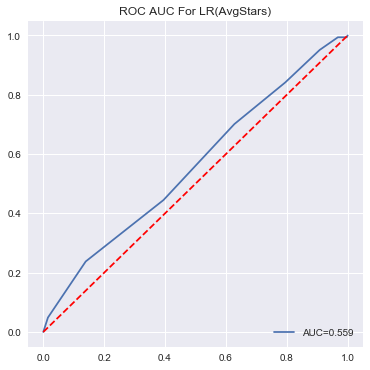

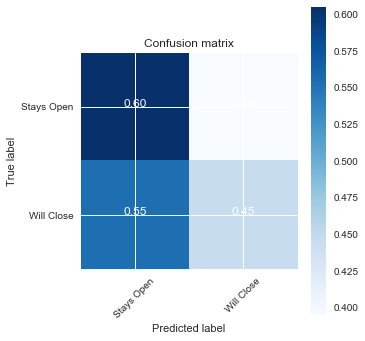

In [29]:
scores = try_model(
    feature_list=['stars'], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(AvgStars)'
)
scores_list.append(scores)

### Rating:

F1       : 0.295
Recall   : 0.445
Precision: 0.221
AUC      : 0.536
CM       : [[395 258]
 [ 91  73]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg)
Features : ['rating']


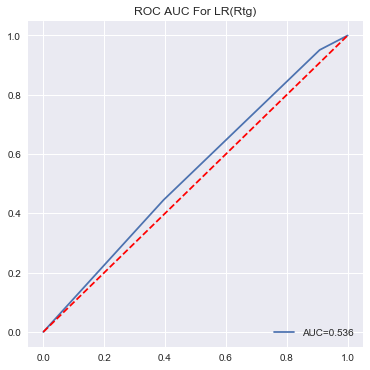

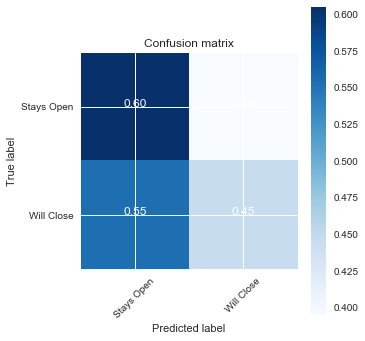

In [30]:
scores = try_model(
    feature_list=[rating_col], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg)'
)
scores_list.append(scores)

### Number of Reviews:

F1       : 0.384
Recall   : 0.768
Precision: 0.256
AUC      : 0.646
CM       : [[286 367]
 [ 38 126]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw)
Features : ['rating', 'review_count']


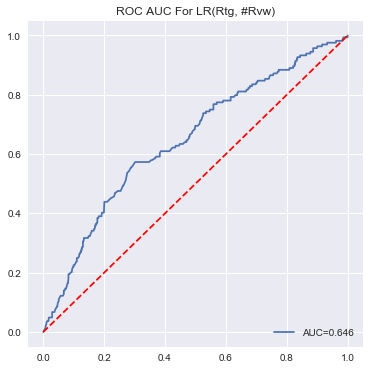

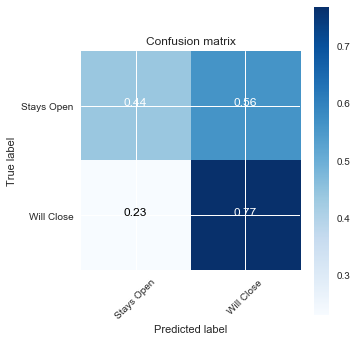

In [31]:
scores = try_model(
    feature_list=[rating_col, 'review_count'], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw)'
)
scores_list.append(scores)

### Zip Code:

F1       : 0.408
Recall   : 0.701
Precision: 0.287
AUC      : 0.662
CM       : [[368 285]
 [ 49 115]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, ZIP)
Features : ['rating', 'review_count', 'zip_89019', 'zip_89039', 'zip_89052', 'zip_89101', 'zip_89102', 'zip_89103', 'zip_89104', 'zip_89106', 'zip_89107', 'zip_89108', 'zip_89109', 'zip_89110', 'zip_89111', 'zip_89113', 'zip_89114', 'zip_89115', 'zip_89117', 'zip_89118', 'zip_89119', 'zip_89120', 'zip_89121', 'zip_89122', 'zip_89123', 'zip_89124', 'zip_89128', 'zip_89129', 'zip_89130', 'zip_89131', 'zip_89134', 'zip_89135', 'zip_89136', 'zip_89138', 'zip_89139', 'zip_89141', 'zip_89142', 'zip_89143', 'zip_89144', 'zip_89145', 'zip_89146', 'zip_89147', 'zip_89148', 'z

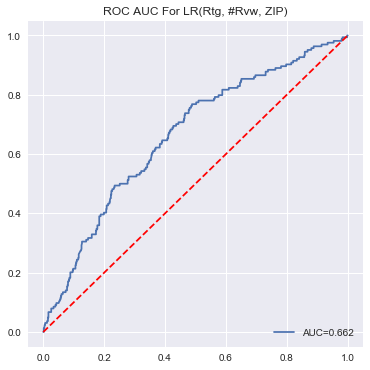

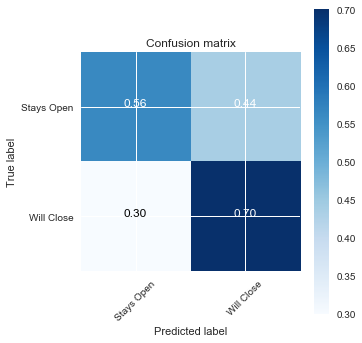

In [32]:
scores = try_model(
    feature_list=[rating_col, 'review_count'] + zip_cols, 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, ZIP)'
)
scores_list.append(scores)

### Business Category:

F1       : 0.402
Recall   : 0.634
Precision: 0.294
AUC      : 0.644
CM       : [[403 250]
 [ 60 104]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, Cat)
Features : ['cat_acai_bowls', 'cat_active_life', 'cat_adult_entertainment', 'cat_african', 'cat_american_new', 'cat_american_traditional', 'cat_arcades', 'cat_arts_entertainment', 'cat_asian_fusion', 'cat_automotive', 'cat_bagels', 'cat_bakeries', 'cat_barbeque', 'cat_bars', 'cat_beer', 'cat_beer_bar', 'cat_brazilian', 'cat_breakfast_brunch', 'cat_breweries', 'cat_british', 'cat_bubble_tea', 'cat_buffets', 'cat_burgers', 'cat_butcher', 'cat_cafes', 'cat_cajun_creole', 'cat_cantonese', 'cat_caribbean', 'cat_casinos', 'cat_caterers', 'cat_cheesesteaks', 'cat_chicken_sh

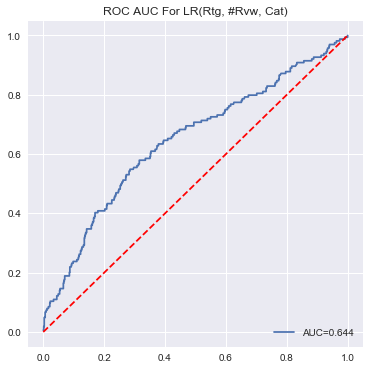

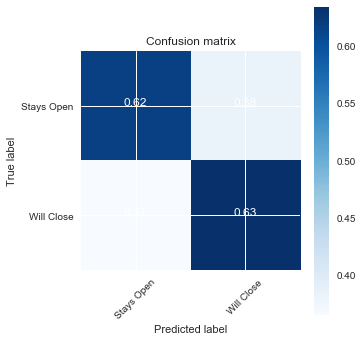

In [33]:
scores = try_model(
    feature_list=[rating_col, 'review_count'] + cat_cols, 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, Cat)'
)
scores_list.append(scores)

### Business per Neighborhood Counts:

F1       : 0.385
Recall   : 0.726
Precision: 0.262
AUC      : 0.653
CM       : [[318 335]
 [ 45 119]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, BPNbr)
Features : ['bpnr_cnt', 'rating', 'review_count']


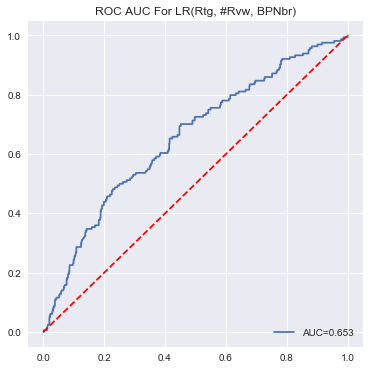

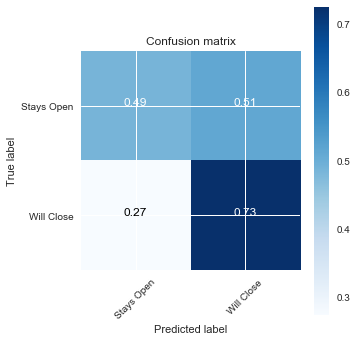

In [34]:
scores = try_model(
    feature_list=[rating_col, 'review_count', bpnbr_cnt_col], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, BPNbr)'
)
scores_list.append(scores)

### Neighborhood:

F1       : 0.387
Recall   : 0.689
Precision: 0.269
AUC      : 0.633
CM       : [[346 307]
 [ 51 113]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, Nbr)
Features : ['nbr_las_vegas_anthem', 'nbr_las_vegas_centennial', 'nbr_las_vegas_chinatown', 'nbr_las_vegas_downtown', 'nbr_las_vegas_eastside', 'nbr_las_vegas_northwest', 'nbr_las_vegas_south_summerlin', 'nbr_las_vegas_southeast', 'nbr_las_vegas_southwest', 'nbr_las_vegas_spring_valley', 'nbr_las_vegas_summerlin', 'nbr_las_vegas_sunrise', 'nbr_las_vegas_the_lakes', 'nbr_las_vegas_the_strip', 'nbr_las_vegas_university', 'nbr_las_vegas_westside', 'rating', 'review_count']


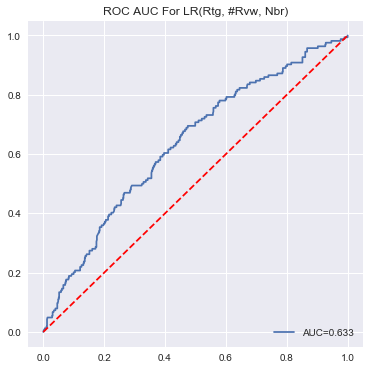

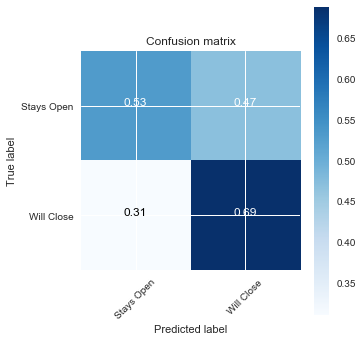

In [35]:
scores = try_model(
    feature_list=[rating_col, 'review_count'] + nbr_cols, 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, Nbr)'
)
scores_list.append(scores)

### Number of Categories:

F1       : 0.371
Recall   : 0.732
Precision: 0.248
AUC      : 0.636
CM       : [[290 363]
 [ 44 120]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, #Cat)
Features : ['cat_cnt', 'rating', 'review_count']


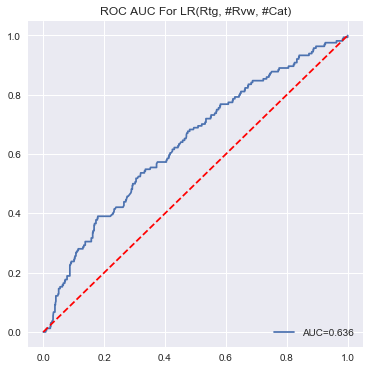

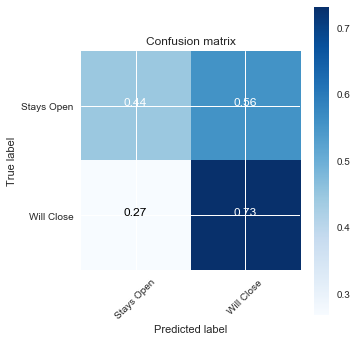

In [36]:
scores = try_model(
    feature_list=[rating_col, 'review_count', cat_cnt_col], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, #Cat)'
)
scores_list.append(scores)

### Num Of Businesses With The Same Name:

F1       : 0.430
Recall   : 0.854
Precision: 0.287
AUC      : 0.720
CM       : [[306 347]
 [ 24 140]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, #Name)
Features : ['rating', 'review_count', 'same_name_cnt']


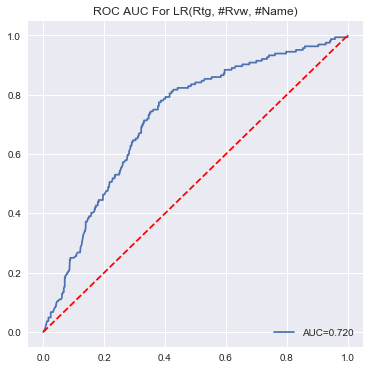

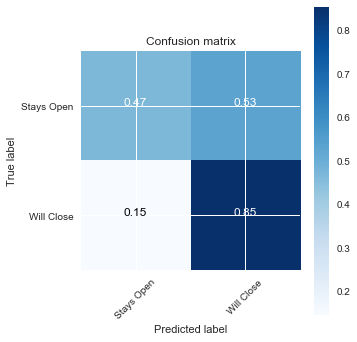

In [37]:
scores = try_model(
    feature_list=[rating_col, 'review_count', same_name_cnt_col], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, #Name)'
)
scores_list.append(scores)

### Num Businesses With The Same Name, Num Businesses Per Neighborhood:

F1       : 0.429
Recall   : 0.841
Precision: 0.287
AUC      : 0.718
CM       : [[311 342]
 [ 26 138]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, #Name, BPNbr)
Features : ['bpnr_cnt', 'rating', 'review_count', 'same_name_cnt']


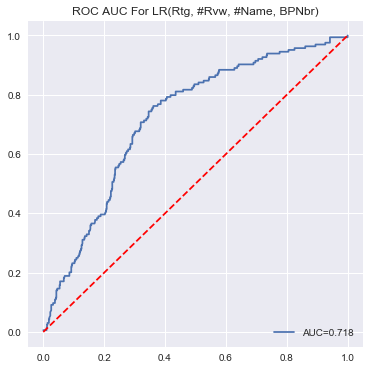

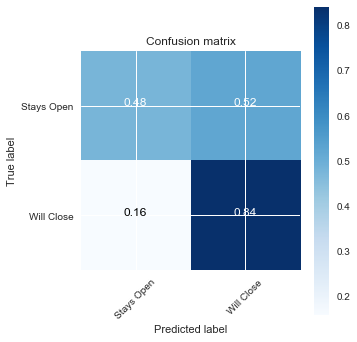

In [38]:
scores = try_model(
    feature_list=[rating_col, 'review_count', same_name_cnt_col, bpnbr_cnt_col], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, #Name, BPNbr)'
)
scores_list.append(scores)

### Review Sentiment:

F1       : 0.456
Recall   : 0.860
Precision: 0.310
AUC      : 0.733
CM       : [[339 314]
 [ 23 141]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, #Name, RvwSntm)
Features : ['rating', 'review_count', 'review_sentiment', 'same_name_cnt']


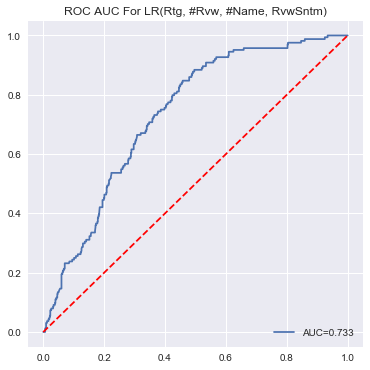

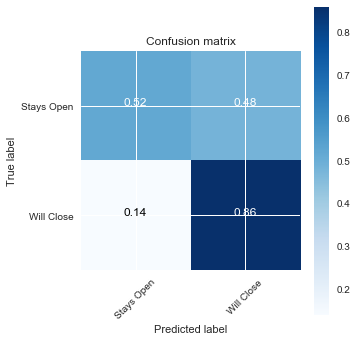

In [39]:
scores = try_model(
    feature_list=[rating_col, 'review_count', same_name_cnt_col, review_sentiment_col], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, #Name, RvwSntm)'
)
scores_list.append(scores)

## Review Sentiment + BPNbr:

F1       : 0.460
Recall   : 0.860
Precision: 0.314
AUC      : 0.734
CM       : [[345 308]
 [ 23 141]]
Model    : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: LR(Rtg, #Rvw, #Name, RvwSntm, BPNbr)
Features : ['bpnr_cnt', 'rating', 'review_count', 'review_sentiment', 'same_name_cnt']


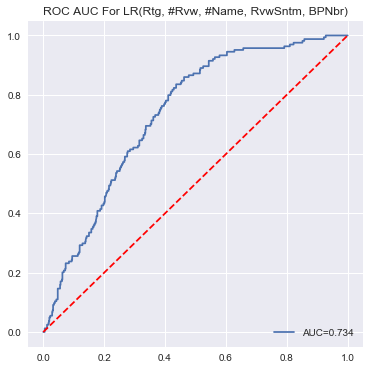

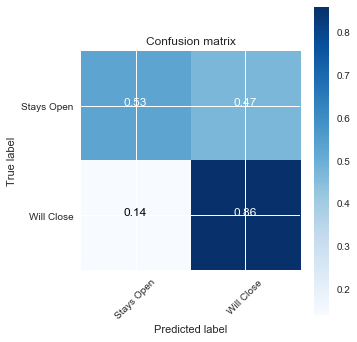

In [40]:
scores = try_model(
    feature_list=[rating_col, 'review_count', same_name_cnt_col, review_sentiment_col, bpnbr_cnt_col], 
    margs=dict(class_weight='balanced'),
    roc_label='LR(Rtg, #Rvw, #Name, RvwSntm, BPNbr)'
)
#scores_list.append(scores)

## Model Selection

In [41]:
from sklearn.ensemble import \
    RandomForestClassifier

In [42]:
def print_feature_importance(scores):
    ds = pd.Series(scores['Model'].feature_importances_,
                   scores['Features'])
    ds.sort_values(ascending=False, inplace=True)
    print(ds.head(100)) 

F1       : 0.281
Recall   : 0.220
Precision: 0.391
AUC      : 0.703
CM       : [[597  56]
 [128  36]]
Model    : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: RF(Rtg, #Rvw, #Name, RvwSntm, BPNbr)
Features : ['bpnr_cnt', 'rating', 'review_count', 'review_sentiment', 'same_name_cnt']


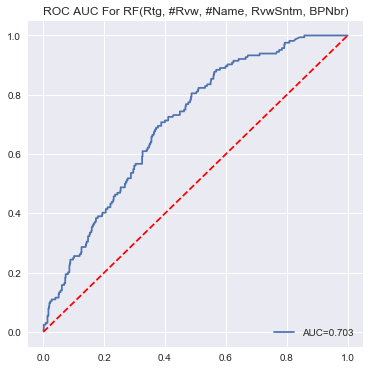

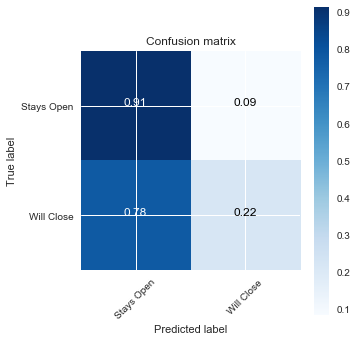

In [43]:
feature_list = []
#feature_list.append('stars')
feature_list.append(rating_col)
feature_list.append('review_count')
#feature_list.extend(zip_cols)
#feature_list.extend(cat_cols)
feature_list.append(same_name_cnt_col)
feature_list.append(bpnbr_cnt_col)
#feature_list.extend(nbr_cols)
#feature_list.append(cat_cnt_col)
feature_list.append(review_sentiment_col)

scores = try_model(
    feature_list=feature_list,
    M=RandomForestClassifier,
    margs=dict(
        class_weight='balanced', 
        n_estimators=1000, 
        max_depth=20, 
        n_jobs=-1,
    ),
    do_scale=False,
    roc_label='RF(Rtg, #Rvw, #Name, RvwSntm, BPNbr)'
)
scores_list.append(scores)

In [44]:
print_feature_importance(scores)

bpnr_cnt            0.406186
same_name_cnt       0.241409
rating              0.165344
review_sentiment    0.149123
review_count        0.037938
dtype: float64


F1       : 0.457
Recall   : 0.500
Precision: 0.421
AUC      : 0.772
CM       : [[540 113]
 [ 82  82]]
Model    : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
ros_ratio: 0
roc_label: RF(All)
Features : ['bpnr_cnt', 'cat_acai_bowls', 'cat_active_life', 'cat_adult_entertainment', 'cat_african', 'cat_american_new', 'cat_american_traditional', 'cat_arcades', 'cat_arts_entertainment', 'cat_asian_fusion', 'cat_automotive', 'cat_bagels', 'cat_bakeries', 'cat_barbeque', 'cat_bars', 'cat_beer', 'cat_beer_bar', 'cat_brazilian', 'cat_breakfast_brunch', 'cat_breweries', 'cat_british', 'cat_bubble_tea', 'cat_buffets', 'cat_

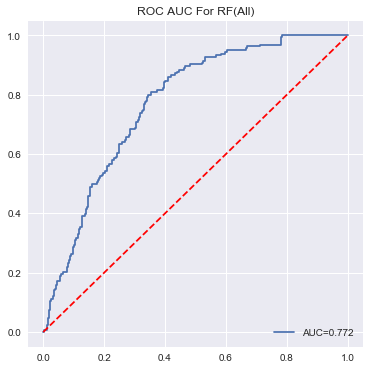

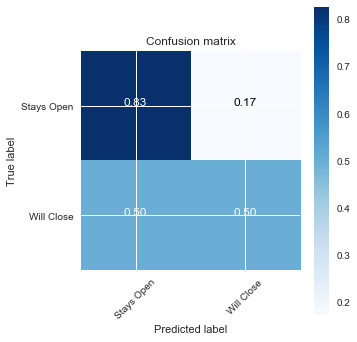

In [45]:
feature_list = []
#feature_list.append('stars')
feature_list.append(rating_col)
feature_list.append('review_count')
feature_list.extend(zip_cols)
feature_list.extend(cat_cols)
feature_list.append(same_name_cnt_col)
feature_list.append(bpnbr_cnt_col)
feature_list.extend(nbr_cols)
feature_list.append(cat_cnt_col)
feature_list.append(review_sentiment_col)

scores = try_model(
    feature_list=feature_list,
    M=RandomForestClassifier,
    margs=dict(
        class_weight='balanced', 
        n_estimators=1000, 
        max_depth=20, 
        n_jobs=-1,
    ),
    do_scale=False,
    roc_label='RF(All)'
)
scores_list.append(scores)

In [46]:
print_feature_importance(scores)

zip_93013                        0.152091
bpnr_cnt                         0.118295
zip_89199                        0.102510
zip_89183                        0.038803
cat_brazilian                    0.031475
cat_seafood                      0.029128
zip_89179                        0.025255
cat_hot_dogs                     0.011923
cat_hookah_bars                  0.011857
zip_89121                        0.010710
rating                           0.010450
cat_soup                         0.009746
cat_lebanese                     0.009726
zip_89109                        0.008259
cat_caribbean                    0.007868
cat_juice_bars_smoothies         0.007617
cat_arts_entertainment           0.007602
cat_bars                         0.007398
nbr_las_vegas_downtown           0.007377
cat_cocktail_bars                0.007035
zip_89139                        0.006797
cat_irish                        0.006619
zip_89019                        0.006320
cat_beer_bar                     0

## Score Evolution

In [47]:
scores_df = pd.DataFrame(
    [
        [ s['Recall'], s['Precision'], s['F1'], s['AUC']]
        for s in scores_list
    ],
    index=[s['roc_label'] for s in scores_list],
    columns=['Recall', 'Precision', 'F1', 'AUC']
)

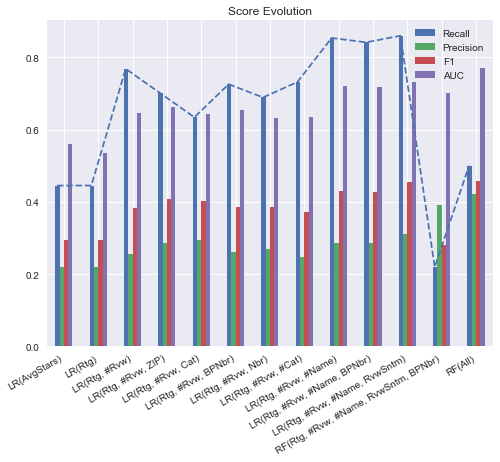

In [48]:
ax = scores_df.plot.bar(
    figsize=(8, 6),
    title='Score Evolution'
)
ax.plot(
    np.arange(len(scores_df.index))-.2,
    scores_df['Recall'],
    '--'
)
for tick in ax.get_xticklabels():
    tick.set(rotation=30, horizontalalignment='right')

In [49]:
[c for c in sorted(yelp_b_df.columns) if (
    not c.startswith('cat_') and
    not c.startswith('nbr_') and
    not c.startswith('zip_')
)]

['address',
 'bpnr_cnt',
 'business_id',
 'city',
 'city_nbr',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'rating',
 'review_count',
 'review_sentiment',
 'same_name_cnt',
 'stars',
 'will_close']

In [51]:
yelp_b_df[yelp_b_df[TARGET_COL] == 0].count()

business_id                      3290
name                             3290
neighborhood                     3290
address                          3290
city                             3290
postal_code                      3290
latitude                         3290
longitude                        3290
stars                            3290
review_count                     3290
is_open                          3290
city_nbr                         3290
nbr_las_vegas_anthem             3290
nbr_las_vegas_centennial         3290
nbr_las_vegas_chinatown          3290
nbr_las_vegas_downtown           3290
nbr_las_vegas_eastside           3290
nbr_las_vegas_northwest          3290
nbr_las_vegas_south_summerlin    3290
nbr_las_vegas_southeast          3290
nbr_las_vegas_southwest          3290
nbr_las_vegas_spring_valley      3290
nbr_las_vegas_summerlin          3290
nbr_las_vegas_sunrise            3290
nbr_las_vegas_the_lakes          3290
nbr_las_vegas_the_strip          3290
nbr_las_vega